# Predicting customer spending at the store

_Given a list of customers, their basic info, and their purchase categories (tech, fashion, etc.), can we predict the total amount they will spend at the store?_

# Table of contents
1. [Background](#Background)
2. [Data ingestion](#Data-ingestion)
3. [Data preprocessing](#Data-preprocessing)
4. [Exploratory Data Analysis](#EDA)
5. [Model Training](#Model-Training)
6. [Testing the Model](#Testing-the-Model)
7. [Conclusion](#Conclusion)
8. [Credits](#Credits)

# Background

## Purpose

Managing a retail store is extremely challenging. With the rise of online purchasing platforms like Amazon or Rakuten, brick-and-mortar store sales are declining at a staggering rate. In 2017, [Statista](https://www.statista.com/statistics/242512/online-retail-visitors-in-the-us-by-age-group/) reported that 67% of millennials and 56% of Generation X prefer online shopping to physical store purchases.  

However, brick-and-mortar stores aren't close to extinct. The [U.S. Department of Commerce](https://www.census.gov/retail/index.html) reported a 2% increase in sales for brick-and-mortar stores.  

To compete with online retail, these stores have to optimize their sales strategy as much as possible. One way to achieve this is through machine learning.  

Cocolevio's machine learning models can tell you what products are selling best, and how much of said product to stock in your store, so you can stop wasting money on inventory that won't sell. 

## Introduction

In this notebook, I used a public dataset from Kaggle, found [HERE](https://www.kaggle.com/mehdidag/black-friday). Thanks in advance to Mehdi Dagdoug and Kaggle for bringing this dataset to the public. Thanks to Analytics Vidhya as well for providing the original dataset. 

The main problem we are trying to solve here is a regression problem. We will try to predict the total purchase amount given the dataset columns.

The dataset columns contain the following information:  

**User_ID, Product_ID, Gender, Purchase** - These should all be self-explanatory, Purchase is in dollars, Product_ID is unique code representing the product.  

**Age** - A set of ranges (eg. 0-17, 26-35) representing the age group purchasing.  

**Occupation** - Customer job. I could not find the mappings from numbers to occupations anywhere, I assume AnalyticsVidhya has hidden them away.  

**City Category** - The mapping is hidden for this column as well, which is unfortunate, but we will still try to model with this column.  

**Stay_In_Current_City_Years** - A range of values from 1 to '4+' representing customer's stay in current city. There are no values beyond 1, 2, 3, 4+.  

**Marital_Status** - There are no mappings for this column, I assumed 0 is not married and 1 is married.  

**Product_Category_1/2/3** - Again, no mappings. We will just have to work with what we have right now. This could possible represent fields such as tech, fashion, etc. 

# Data ingestion

## Initial thoughts

This dataset seems to contain a decent amount of information, yet none of this information is clearly shown to the user. It is unfortunate that we will have almost no real-world knowledge of what columns like City_Category or Occupation mean, as that would be extremely useful in future classification or clustering problems. 

Since we are doing a regression approach on the purchase amount, we will need to clean all of this data and prepare it for analysis. Even without the real-world mappings, we should still be able to make a decent regression model for the purchase total.

# Data preprocessing

The purpose of the data preprocessing stage is to minimize potential error in the model as much as possible. Generally, a model is only as good as the data passed into it, and the data preprocessing we do ensures that the model has as accurate a dataset as possible. While we cannot perfectly clean the dataset, we can at least follow some basics steps to ensure that our dataset has the best possible chance of generating a good model. 

First, let's check and see null values for this dataset. Null values are empty, useless entries within our dataset that we don't need. If we skip removing null values, our model will be inaccurate as we create "connections" for useless values, rather than focusing all resources onto creating connections for useful values. 

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('BlackFriday.csv')
print(df.head())

   User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          2               0                   3   
1                          2               0                   1   
2                          2               0                  12   
3                          2               0                  12   
4                         4+               0                   8   

   Product_Category_2  Product_Category_3  Purchase  
0                 NaN                 NaN      8370  
1                 6.0                14.0     15200  
2                 NaN                 NaN   

In [2]:
print("Presence of null values: " + str(df.isnull().values.any()))

Presence of null values: True


Looks like we will have to analyze where exactly our null values are occuring. Let's check the distributions of the null values in our dataset. 

In [3]:
df1 = df.describe(include = 'all')

df1.loc['dtype'] = df.dtypes
df1.loc['size'] = len(df)
df1.loc['% count'] = df.isnull().mean()
print(df1)

             User_ID Product_ID  Gender     Age Occupation City_Category  \
count         537577     537577  537577  537577     537577        537577   
unique           NaN       3623       2       7        NaN             3   
top              NaN  P00265242       M   26-35        NaN             B   
freq             NaN       1858  405380  214690        NaN        226493   
mean     1.00299e+06        NaN     NaN     NaN    8.08271           NaN   
std          1714.39        NaN     NaN     NaN    6.52412           NaN   
min            1e+06        NaN     NaN     NaN          0           NaN   
25%       1.0015e+06        NaN     NaN     NaN          2           NaN   
50%      1.00303e+06        NaN     NaN     NaN          7           NaN   
75%      1.00442e+06        NaN     NaN     NaN         14           NaN   
max      1.00604e+06        NaN     NaN     NaN         20           NaN   
dtype          int64     object  object  object      int64        object   
size        

In [4]:
print(df.isna())

        User_ID  Product_ID  Gender    Age  Occupation  City_Category  \
0         False       False   False  False       False          False   
1         False       False   False  False       False          False   
2         False       False   False  False       False          False   
3         False       False   False  False       False          False   
4         False       False   False  False       False          False   
5         False       False   False  False       False          False   
6         False       False   False  False       False          False   
7         False       False   False  False       False          False   
8         False       False   False  False       False          False   
9         False       False   False  False       False          False   
10        False       False   False  False       False          False   
11        False       False   False  False       False          False   
12        False       False   False  False       Fa

There are some revelations here. It seems as if our dataset columns are not all numbers, even though they look like they are. There are also a lot of NaN values, but thankfully they're mostly focused in Product_Category_2/3, so we will not have to do much tweaking. 

Our next steps involve using scikit-learn's LabelEncoder package to map categorical data to numerical values. Categorical data is non-numeric data, meaning that it doesn't relate to a number. We should also temporarily insert 0s into the NaN values in the Product_Category null values. This will be a temporary measure until we can figure out the importance of Product_Category 2/3 in the EDA section.

In [12]:
from sklearn.preprocessing import LabelEncoder

df['Product_Category_2'] = df['Product_Category_2'].fillna(value=0)
df['Product_Category_3'] = df['Product_Category_3'].fillna(value=0)

col_names = df.columns.values
col_names = np.delete(col_names, 11)
col_names = np.delete(col_names, 3)
col_names = np.delete(col_names, 3)

lbl = LabelEncoder()

for col in col_names:
    df[col] = lbl.fit_transform(df[col].values)

['User_ID' 'Product_ID' 'Gender' 'City_Category'
 'Stay_In_Current_City_Years' 'Marital_Status' 'Product_Category_1'
 'Product_Category_2' 'Product_Category_3']


Here, we can now see that we've labelled our categorical data, and changed the object-type columns to be of type int32/64. Now, we can also choose what columns we want to use for our regression predictions. For my use case, User_ID and Product_ID were mostly useless, so I decided to drop them. I also dropped Product_Category 2/3 since a lot of the values turned out to be ex-null values. This is okay to do since having so many null values in our model would reduce the accuracy of our predictions and analysis. 

In [14]:
df.pop('User_ID')
df.pop('Product_ID')
df.pop('Product_Category_2')
df.pop('Product_Category_3')

0          0
1         11
2          0
3          0
4          0
5          0
6         14
7          0
8          0
9          0
10         0
11         0
12         0
13         3
14        11
15         0
16         2
17         0
18        13
19        12
20         0
21         0
22         0
23         0
24        11
25         0
26         0
27         0
28        11
29         5
          ..
537547    12
537548     0
537549    11
537550     0
537551     5
537552     0
537553     0
537554     0
537555     0
537556     0
537557     0
537558     0
537559     0
537560     0
537561     0
537562    11
537563     0
537564     0
537565     0
537566     0
537567     0
537568     0
537569     0
537570     0
537571     3
537572     0
537573    13
537574     0
537575     0
537576     0
Name: Product_Category_3, Length: 537577, dtype: int64

We can now move onto data analysis and correlations. 

# EDA

The purpose of EDA is to enhance our understanding of trends in the dataset without involving complicated machine learning models. Oftentimes, we can see obvious traits using graphs and charts just from plotting columns of the dataset against each other.

After the preprocessing, we can use seaborn's correlation heatmap to get a better gauge on what we want to emphasize/de-emphasize. 

Let's create a correlation map to see the relations between different features.  

A correlation map (or correlation matrix) is a visual tool that illustrates the relationship between different columns of the dataset. The matrix will be lighter when the columns represented move in the same direction together, and it will be darker when one column decreases while the other increases. Strong spots of light and dark spots in our correlation matrix tell us about the future reliabilty of the model. 

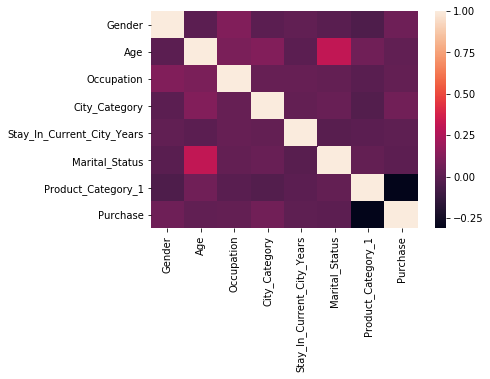

In [16]:
import seaborn as sns

corr = df.corr()
sns.heatmap(corr)

From the correlation map, we can see a large negative correlation between Purchase and Product_Category_1. There is also a strong correlation between Age and Marital Status, which makes sense as well. However, we don't have many strong correlation points between our columns aside from the ones mentioned above. This is a problem because our model needs decent correlations between the data columns in order to make accurate predictions.

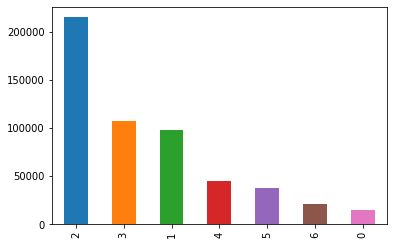

In [17]:
pd.value_counts(df['Age']).plot.bar()

We can see that there is a large proportion of the customers in the  26-35 range, followed by the next largest at 36-45 range. Marketing products towards college grads and people between 26-45 range seem to generate the most sales on Black Friday. Let's plot the occupations as well to see what's most represented within the dataset. 

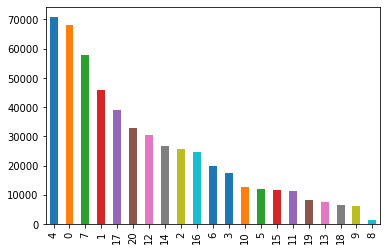

In [18]:
pd.value_counts(df['Occupation']).plot.bar()

Occupations 4, 0, 7 are much more heavily represented within this dataset compared to the others. Unfortunately, we don't have a proper mapping between the categorical and numerical data, so we can't infer much beyond simply observing the data. As a retailer, focusing on objects purchased by Occupations 4, 0, and 7 seem to be the way to go to maximize total number of sales. 

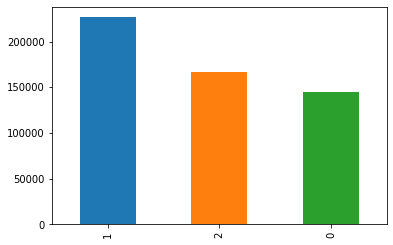

In [19]:
pd.value_counts(df['City_Category']).plot.bar()

Again, we don't have enough categorical information to make sense of the data, but it seems that City_Category 1 has the most retail sales compared to the other two city types. This could potentially lead to insights in spending habits between different cities (e.g spending is higher in NYC retail stores compared to retail stores in Tuscaloosa). 

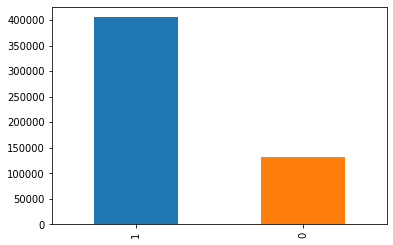

In [20]:
pd.value_counts(df['Gender']).plot.bar()

This factor is much more interesting. With 1 being Male and 0 being Female, we can see that there are significantly more males than females on Black Friday shopping. As for the reasoning behind this distribution, there may be more sales on male-oriented items compared to female oriented items. Either way, as a retailer, it seems to be better to stock more male-oriented products on Black Friday to generate the most sales.  

It also makes sense to market to women as well, since not many retailers are pursuing the group. By capitalizing on the women's market, your company can gain a concrete advantage while other companies lose more money competing for male customers. 

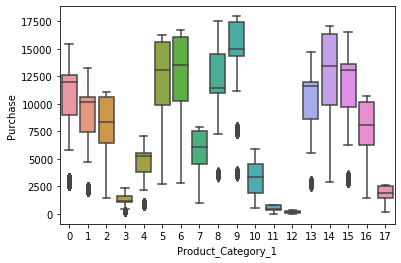

In [36]:
sns.boxplot(x = 'Product_Category_1', y = 'Purchase', data = df)

It seems as if Product_Category_1 has it's most purchased items on average in category 9, followed by categories 5, 6, 14, and 15. For retailers, this could mean that it is better to stock more of those items to get the most sales. 

Now that we have done our analysis for this dataset, we can begin building and training our models.

# Model Training

In this section, we will be creating and training our model for predicting how much a customer will spend at a retail store. Since there are multiple algorithms we can use to build our model, we will compare the accuracy scores after testing and pick the most accurate algorithm.

Let's begin by importing the different regression algorithms we will be using for prediction.

In [21]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

Now, we can begin building and training our model.

From this list, we are using XGBoost, DecisionTree, RandomForest, LogisticRegression, SVC, and KNeighborsRegressor to perform our predictions. We will then see which algorithm produces the lowest root mean squared error (RMSE) and select it as our algorithm of choice for future use. We also want to partition our dataset into training, testing, and validation, so let's add a method for that ability. 

Our testing will take three phases: testing, training, and validation. Training is first, and it's where our model generates "intuition" about how to approach fraudulent and not fraudulent transactions. It is similar to a student studying and developing knowledge about a topic before an exam.  

The testing phase is where we see how the model performs against data where we know the outcome. This would be the exam if we continue the analogy from before. The algorithms will perform differently, similar to how students will score differently on the exam. From this phase, we generate an accuracy score to compare the different algorithms.  

The validation testing is how we check that the model isn't overfitting to our specific dataset. Overfitting is when the model starts to develop an intuition that is too specific to the training set. Overfitting is a problem because our model is no longer flexible. It may work on the initial set, but subsequent uses will cause our model to fail. Continuing the exam analogy, the validation testing phase is like another version of the exam with different questions. If a student happened to cheat on the first exam by knowing the questions, the second exam will give a better representation of performance.  

Note that verification doesn't completely disprove or prove overfitting, but the testing does give insight about it. 

In [25]:
from sklearn.model_selection import train_test_split

training,test = train_test_split(df, train_size = 0.7, test_size = 0.3, shuffle=True)
training, valid = train_test_split(training, train_size = 0.7, test_size =0.3, shuffle=True)

training_label = training.pop('Purchase')
test_label = test.pop('Purchase')
valid_label = valid.pop('Purchase')

Now, we can begin building and training our model.

We now instantiate our different algorithms to begin training the model. 

In [26]:
# instantiate training models 
xgb = XGBRegressor()
dtc = DecisionTreeRegressor()
rfc = RandomForestRegressor()
knn = KNeighborsRegressor(n_neighbors=3)

In [27]:
# train the models
xgb.fit(training, training_label)
dtc.fit(training, training_label)
rfc.fit(training, training_label)
knn.fit(training, training_label)

c:\users\tgmat\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\tgmat\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:09:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\tgmat\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

This dataset is very large (500k+ rows), so it will take some time to train our models, especially for the slower algorithms. 

The training label for this use case is the purchase amount from each person. Since we are trying to predict a number, we are solving a regression problem, hence why we used the regression algorithms.

Our model has been trained, now let's move on to testing.

# Testing the Model

Below is the code for testing our model:

In [28]:
xgb_predict = xgb.predict(test)
dtc_predict = dtc.predict(test)
rfc_predict = rfc.predict(test)
knn_predict = knn.predict(test)

Since we are doing regression, we use sklearn's built-in mean_squared_error() method and then use math.sqrt() to get the RMSE value. 

In [29]:
from sklearn.metrics import mean_squared_error
import math

accuracy = dict()
accuracy['XGBoost'] = math.sqrt(mean_squared_error(test_label, xgb_predict))
accuracy['DecisionTree'] = math.sqrt(mean_squared_error(test_label, dtc_predict))
accuracy['RandomForest'] = math.sqrt(mean_squared_error(test_label,rfc_predict))
accuracy['KNN'] = math.sqrt(mean_squared_error(test_label,knn_predict))

print(accuracy)

{'XGBoost': 2463.9493716957895, 'DecisionTree': 2470.5844387341845, 'RandomForest': 2439.5589418390937, 'KNN': 2762.9770146527535}


These RMSE values are very large, especially given the data we are working with. We will have to fine tune our model to get better numbers. However, remember that in our correlation graph, there were very few correlated variables, so it is expected that our model produces very skewed values. 

In [30]:
xgb_predict = xgb.predict(valid)
dtc_predict = dtc.predict(valid)
rfc_predict = rfc.predict(valid)
knn_predict = knn.predict(valid)

# judge accuracy using built-in function
accuracy['XGBoost'] = math.sqrt(mean_squared_error(valid_label, xgb_predict))
accuracy['DecisionTree'] = math.sqrt(mean_squared_error(valid_label, dtc_predict))
accuracy['RandomForest'] = math.sqrt(mean_squared_error(valid_label,rfc_predict))
accuracy['KNN'] = math.sqrt(mean_squared_error(valid_label,knn_predict))

print(accuracy)

{'XGBoost': 2467.7929512047444, 'DecisionTree': 2475.4688039178195, 'RandomForest': 2447.2282815365447, 'KNN': 2781.80780730333}


Again, as stated above, this is expected due to the lack of correlation between our columns. We are limited mostly by the quality of our dataset, since there are so many null values and outliers that affect our error accuracy. 

In [31]:
results = pd.DataFrame({'label mpg': valid_label, 
                        'prediction': xgb.predict(valid)})
results.head()

,label mpg,prediction
210696,9921,11619.172852
247527,232,1796.697266
107699,14030,11401.705078
431514,4699,5702.896973
207541,5253,4695.608887


That's not very good at predicting. It appears that the 232 is an outlier in our dataset, meaning that we should mostly likely do some normalization and remove outliers in the EDA section. However, even with the outliers removed, we would probably still have an inaccuracy of ~$1000 due to the quality of our dataset for testing and training.  

Almost all of the categorical data present in the dataset has been mapped with an algorithm that wasn't given to us, so we have very few options in terms of fixing the error. 

Let's plot the error values of each algorithm to visualize the differences between them.

,Algorithms,RMSE
0,XGBoost,2467.792951
1,DecisionTree,2475.468804
2,RandomForest,2447.228282
3,KNN,2781.807807


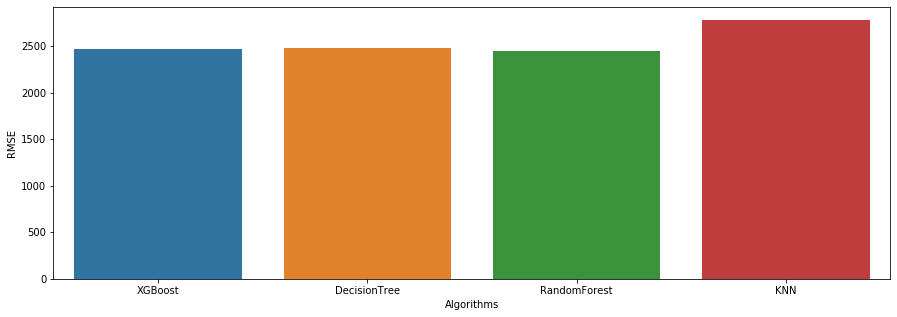

In [33]:
import matplotlib.pyplot as plt

fig, (ax1) = plt.subplots(ncols=1, sharey=True,figsize=(15,5))

new_df=pd.DataFrame(list(accuracy.items()),columns=['Algorithms','RMSE'])
display(new_df)
sns.barplot(x="Algorithms", y="RMSE", data=new_df,ax=ax1);

From the above graph, we can see that the error reaches an average of around $2455 for XGBoost, DecisionTree, and RandomForest. KNearestNeighbors algorithm has a higher error though, since the presence of outliers is more likely to affect KNN than the other 3. 

We select the lowest RMSE value and save it for later use. 

In [37]:
max_accuracy = min(accuracy,key=accuracy.get)

max_accuracy

'RandomForest'

# Conclusion

In this notebook, we analyzed retail spending data and tried to predict the amount a customer would spend, given items such as Marital Status, Age, and Product Category.  

While our spending prediction model wasn't very accurate, we did see some unique patterns in Black Friday spending. For example, men purchase significantly more on Black Friday than women do. This may be due to a lack of marketing campaign for women's products on Black Friday.  

Another insight came from the age demographics, which show that people between ages 26-35 purchase significantly more than other age groups on Black Friday. This could lead to shifts in products catering toward that age demographic.  

We also saw that some product categories significantly outperformed other categories on Black Friday. Since we don't have the categorical data mappings, we can't accurately tell what the actual category is, but if technology was high in demand, stores like Best Buy could emphasize more sales on Black Friday to boost income. If stores like TJ Maxx had product categories that didn't perform well, they could add more lucrative sales to that product type in order to entice more sales in an untapped market.  

Regardless of results, this notebook shows the power of data analysis, and how impactful it is on making smart business decisions. Instead of making blind guesses using small talk and untruthfully answered surveys, businesses can simply analyze their own sales data to gain key insights on what works for their business, and what doesn't work. 

Cocolevio's data analytics experience can help you get the most out of your data. Find out what your customers want, and don't want, using our powerful automated machine learning tool, 5411. 

# Credits

Thanks again to the people I've mentioned in the introduction for providing this dataset, and to the Kaggle community for teaching me a lot of what allowed me to do this analysis. 

Even though our model prediction was not very good, the EDA section still revealed some interesting trends. On average, significantly more males are purchasing items on Black Friday compared to females. Likewise, products in category 9 sell significantly more than the other products.

While our model may not be extremely useful, our data analysis was the critical component for retailers. 